In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
from transformers import BertTokenizer, AutoModel
from pathlib import Path
from tqdm import tqdm
import pickle
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from Bio.SeqUtils.ProtParam import ProteinAnalysis

import warnings
warnings.filterwarnings('ignore')
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from src.utils import load_config, seed_everything, get_embed, train_classifier

In [2]:
# for reproducibility
seed_everything(42)

# config file
config = load_config("../configs/config.yaml")

# Set Seaborn style
sns.set(style=config['sns_params']['style'],
        palette=config['sns_params']['palette'],
        font_scale=config['sns_params']['font_scale'])

# Set Matplotlib parameters
plt.rcParams.update(config['plt_params'])

### Read files

In [3]:
df_glycan = pd.read_pickle(config['paths']['df_glycan_path'])
df_species = pd.read_pickle(config['paths']['df_species_path']).drop('ref', axis=1).drop_duplicates()
df_bind = pd.read_pickle(config['paths']['glycan_binding_path'])
df_glycan_list = pd.read_csv(config['paths']['glycan_list_path'])
df_Nglycan = pd.read_pickle(config['paths']['N_glycans_df_path'])


list of all glycan sequences to embed via GlycoFormer:

In [4]:
all_glycan_seqs = list(set(df_glycan['glycan'].tolist() +
                           df_species['glycan'].tolist() +
                           df_bind.columns.tolist() +
                           df_glycan_list['glycan'].tolist() +
                           df_Nglycan['glycan'].tolist()))

### Calculate embedding for all glycans

load the model and tokenizer (first try local files, otherwise fetch from huggingface):

In [ ]:
# Load the tokenizer
tokenizer = BertTokenizer.from_pretrained(config['paths']['tokenizer'])

# Load model
model_path = config['paths']['model'] + 'checkpoint-48070/'

if Path(model_path+'model.safetensors').is_file():
    print('loading model locally')
    model = AutoModel.from_pretrained(model_path)
else:
    print('loading model from hugging face')
    model = AutoModel.from_pretrained('AliSaadatV/GlycoFormer')

glycan embedding calculation (if already done, load from local file. Otherwise calculate them):

In [6]:
# read embeddings
if Path(config['paths']['embeds']).is_file():
    with open(config['paths']['embeds'], "rb") as file:
        all_embeds = pickle.load(file)

# or calculate embeddings
else:
    all_embeds = {}

    for glycan_seq in tqdm(all_glycan_seqs, desc="Processing glycans"):
        try:
            glycan_embed = get_embed(glycan_seq, model, tokenizer)
            all_embeds[glycan_seq] = glycan_embed.squeeze().half().tolist()
        except Exception as e:
            print(f"Error processing {glycan_seq}: {e}")
            all_embeds[glycan_seq] = "NA"

    # Save the dictionary to a file
    with open(config['paths']['embeds'], "wb") as file:
        pickle.dump(all_embeds, file)

### Visualize in 2D

GlycoFormer embeddings are in a 768 dimentional space. To visualize them, we put all the embeddings in a dataframe (rows are glycans, columns are embedding values) and use PCA:

In [7]:
# convert to df
all_embeds_df = pd.DataFrame(all_embeds).T
embeds_cols = ['embed' + str(x) for x in range(all_embeds_df.shape[1])]
all_embeds_df.columns = embeds_cols
all_embeds_df = all_embeds_df[all_embeds_df['embed0']!='NA']
all_embeds_df.reset_index(inplace=True)
all_embeds_df.rename(columns={"index": "glycan"}, inplace=True)

# add species and Nglycan information
all_embeds_df['N-Glycan'] = 0
all_embeds_df.loc[all_embeds_df.glycan.isin(df_Nglycan.glycan.tolist()), 'N-Glycan'] = 1

all_embeds_df.head()

,glycan,embed0,embed1,embed2,embed3,embed4,embed5,embed6,embed7,embed8,...,embed759,embed760,embed761,embed762,embed763,embed764,embed765,embed766,embed767,N-Glycan
0,Neu5Gc(a2-?)Gal(b1-?)[Fuc(a1-?)]GlcNAc(b1-?)[G...,-0.958984,-0.539551,-0.283936,0.336182,0.460693,-0.565918,-0.901367,-0.14563,-0.279785,...,-0.317383,0.114014,-0.142456,0.178589,-0.637207,0.078003,0.15564,0.119385,-1.519531,0
1,Gal(b1-4)GlcNAc(b1-2)Man(a1-3)[Gal(b1-4)GlcNAc...,-0.805176,-0.779297,-0.009369,0.137207,0.433838,-0.572754,-0.724609,-0.115234,-0.273438,...,-0.030487,0.153931,0.002018,0.442383,-0.515625,-0.226685,0.188843,-0.056152,-1.230469,0
2,Gal(b1-4)GlcN(b1-2)[Gal(b1-4)GlcN(b1-4)]Man(a1...,-0.732422,-0.741211,-0.023468,0.53125,0.410889,-0.505859,-0.692871,0.330322,0.073792,...,-0.383545,0.027725,0.060516,0.485596,-0.486816,-0.241211,0.176147,-0.025833,-1.209961,0
3,Gal(a1-3)Glc(a1-3)Rha(a1-4)RibOP-ol,-0.969238,-0.588379,-0.083984,0.462891,0.14917,-0.523926,-0.316895,-0.252441,0.30249,...,-0.276855,0.065186,-0.017593,0.199341,-0.59668,-0.365234,0.429688,-0.378906,-0.922363,0
4,Gal(b1-4)GlcNAc(b1-2)[Gal(b1-3)GlcNAc(b1-4)]Ma...,-0.8125,-0.793945,-0.036072,0.268799,0.460938,-0.5625,-0.809082,-0.121338,-0.114929,...,0.040527,0.133301,-0.034973,0.446533,-0.513672,-0.161377,0.304199,-0.067322,-1.334961,0


Reduce embedding dimention using PCA (to keep 80% of variation). This results in 14 PCs:

In [8]:
pca = PCA(n_components=0.8)
all_embeds_pcs = pca.fit_transform(all_embeds_df[embeds_cols])
pc_cols = [f'PC{x}' for x in range(all_embeds_pcs.shape[1])]
all_embeds_df[pc_cols] = all_embeds_pcs
all_embeds_df.head()

,glycan,embed0,embed1,embed2,embed3,embed4,embed5,embed6,embed7,embed8,...,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13
0,Neu5Gc(a2-?)Gal(b1-?)[Fuc(a1-?)]GlcNAc(b1-?)[G...,-0.958984,-0.539551,-0.283936,0.336182,0.460693,-0.565918,-0.901367,-0.14563,-0.279785,...,1.480678,0.980994,0.073746,0.205785,0.506269,0.404798,-0.874783,-0.087419,0.259114,-0.417196
1,Gal(b1-4)GlcNAc(b1-2)Man(a1-3)[Gal(b1-4)GlcNAc...,-0.805176,-0.779297,-0.009369,0.137207,0.433838,-0.572754,-0.724609,-0.115234,-0.273438,...,1.143507,0.767886,0.161981,-0.047577,-0.414406,1.349270,-0.632793,0.111534,-0.247217,0.224514
2,Gal(b1-4)GlcN(b1-2)[Gal(b1-4)GlcN(b1-4)]Man(a1...,-0.732422,-0.741211,-0.023468,0.53125,0.410889,-0.505859,-0.692871,0.330322,0.073792,...,-0.300653,-1.469427,1.529286,1.055386,-0.563166,2.586662,0.477525,-0.979073,0.261581,-0.660357
3,Gal(a1-3)Glc(a1-3)Rha(a1-4)RibOP-ol,-0.969238,-0.588379,-0.083984,0.462891,0.14917,-0.523926,-0.316895,-0.252441,0.30249,...,-2.580481,-1.840078,0.021948,0.763603,0.171893,-2.167540,-0.722963,1.902597,-0.767345,-0.223638
4,Gal(b1-4)GlcNAc(b1-2)[Gal(b1-3)GlcNAc(b1-4)]Ma...,-0.8125,-0.793945,-0.036072,0.268799,0.460938,-0.5625,-0.809082,-0.121338,-0.114929,...,0.868913,0.219844,0.045439,0.288662,-0.493306,1.151964,-0.381339,0.758874,-0.032076,0.544092


For embedding validation, we look at the closeness of N-glycans, and observe the they cluster in the embedding space:

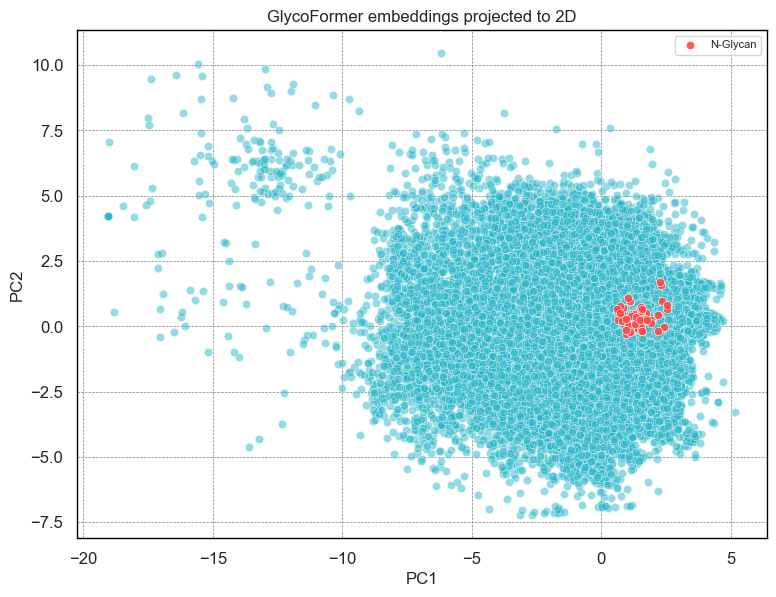

In [9]:
plt.figure()
sns.scatterplot(all_embeds_df[all_embeds_df['N-Glycan']==0], x='PC1', y='PC2', alpha=0.5, color='#2ab7ca')
sns.scatterplot(all_embeds_df[all_embeds_df['N-Glycan']==1], x='PC1', y='PC2', alpha=0.9, color='#fe4a49', label='N-Glycan')
plt.tight_layout()
plt.title('GlycoFormer embeddings projected to 2D')
plt.savefig(config['paths']['figures_dir']+'/embeddings_pca_colorNglycan.png')
plt.show()

Just for visualization, we can also color the dots using the "Domain":

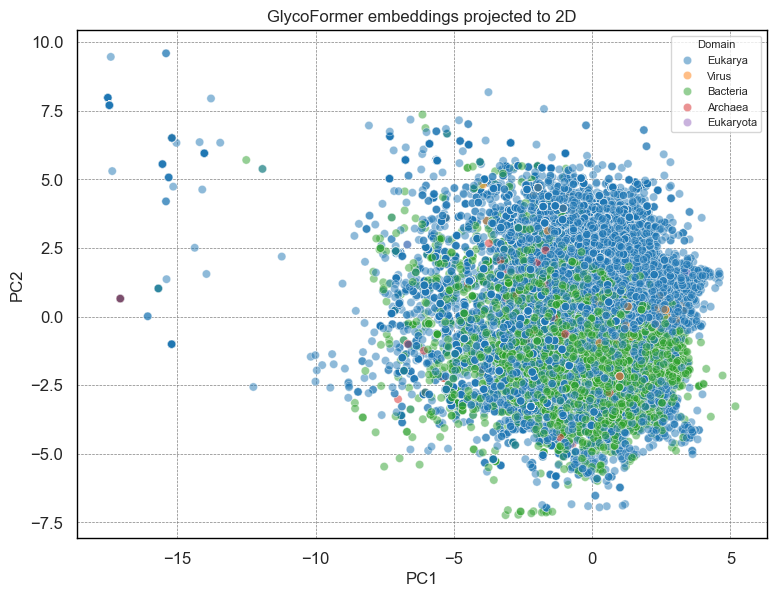

In [10]:
plt.figure()
sns.scatterplot(all_embeds_df.merge(df_species, how='left'), x='PC1', y='PC2', alpha=0.5, hue='Domain', palette='tab10')
plt.tight_layout()
plt.title('GlycoFormer embeddings projected to 2D')
plt.savefig(config['paths']['figures_dir']+'/embeddings_pca_colorDomain.png')
plt.show()

### Using embeddings for prediction

#### 1. Species prediction

First task is uing embeddings for Species prediction. Since there are a lot of rare and infrequent Species in the data frame, we can focus on the top 10 frequent species:

In [11]:
# keep only top K frequent species 
K = 10
frequent_species = df_species[df_species['Species']!='undetermined']['Species'].value_counts()[0:K].index
df_species_frequent = df_species[df_species['Species'].isin(frequent_species)].copy()

# one hot encoding
oh_enc = OneHotEncoder()
labels_oh = oh_enc.fit_transform(df_species_frequent[['Species']])
labels_names = oh_enc.get_feature_names_out().tolist()
df_species_frequent[labels_names] = labels_oh.toarray()

# add embeddings
df_species_frequent = df_species_frequent.merge(all_embeds_df[['glycan'] + embeds_cols], how = 'left').dropna()

# remove duplicates
df_species_frequent = df_species_frequent[~df_species_frequent[embeds_cols].duplicated()]

Train a logistic regression model and evaluate:

In [12]:
model_species, f1_macro, f1_all_labels, accuracy = train_classifier(df_species_frequent, embeds_cols, labels_names, multi_label=True, max_iter=200, n_jobs=4, normalize=True)

In [13]:
print(f'F1 macro is {f1_macro},\nAccuracy is {accuracy}')

F1 macro is 0.39393614698613943,
Accuracy is 0.6135458167330677


Evaluate the performance per label:

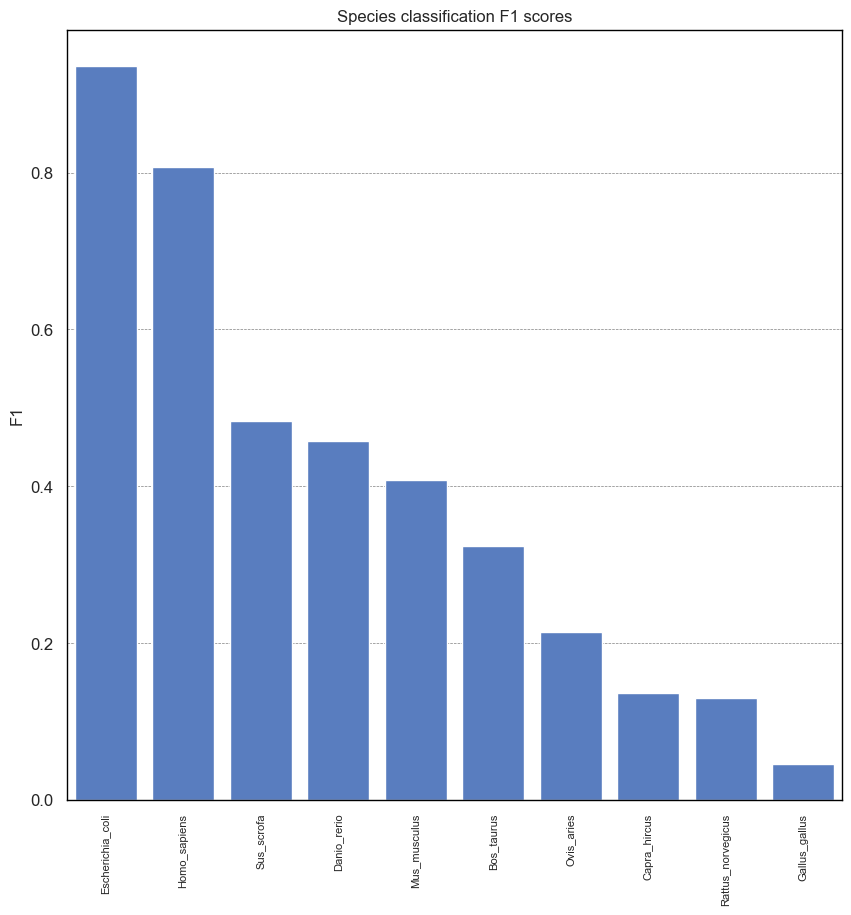

In [14]:
f1_all_labels_df = pd.DataFrame({'F1': f1_all_labels, 'Species': [x[8:] for x in labels_names]})
f1_all_labels_df = f1_all_labels_df.sort_values(by='F1', ascending=False)

plt.figure(figsize=(10, 10))
sns.barplot(data=f1_all_labels_df, x='Species', y='F1')
plt.xticks(rotation=90, fontsize=8)
plt.xlabel(None)
plt.title('Species classification F1 scores')
plt.savefig(config['paths']['figures_dir']+'/species_classification.png')
plt.show()

#### 2. Disease prediction

Second task is disease prediction. Since this task has much smaller dataset, we use PCs for predicting the disease association. We focus on diseases that have at least 20 samples.

In [15]:
# create a list of all diseases
all_diseases_list = []

for idx, row in df_glycan.iterrows():
    all_diseases_list += row['disease_association']

all_diseases_list = list(set(all_diseases_list))
all_diseases_list.remove('')
print(f'there are {len(all_diseases_list)} total diseases')

# create dataframe with glycan and diseases
df_disease = df_glycan[['glycan', 'disease_association']].copy()
df_disease[all_diseases_list] = 0
keep_glycan = []

for idx, row in df_disease.iterrows():
    temp_diseases = row['disease_association']

    if '' in temp_diseases:
        temp_diseases.remove('')
    
    if len(temp_diseases) > 0:
        keep_glycan.append(row['glycan'])
        
        for disease in temp_diseases:
            if disease != '':
                df_disease.at[idx, disease] = 1

df_disease = df_disease[df_disease.glycan.isin(keep_glycan)]

K = 20
all_diseases_list_threshold = [x for x in all_diseases_list if df_disease[x].sum()>K] # keep diseases (columns) with at least K samples

print(f'there are {len(all_diseases_list_threshold)} diseases with at least {K} samples')

df_disease = df_disease[df_disease[all_diseases_list_threshold].sum(axis=1) > 0] # make sure to keep rows that have at least one disease

print(f'there are {len(df_disease)} glycans with disease association')

there are 59 total diseases
there are 10 diseases with at least 20 samples
there are 444 glycans with disease association


In [16]:
# add embeddings
df_disease = df_disease.merge(all_embeds_df[['glycan'] + pc_cols], how = 'left').dropna()

# remove duplicates
df_disease = df_disease[~df_disease[pc_cols].duplicated()]

Train and evaluate:

In [17]:
model_disease, f1_macro, f1_all_labels, accuracy = train_classifier(df_disease, pc_cols, all_diseases_list_threshold, multi_label=True, max_iter=200, n_jobs=4, normalize=True)

In [18]:
print(f'F1 macro is {f1_macro},\nAccuracy is {accuracy}')

F1 macro is 0.4798815426060008,
Accuracy is 0.4044943820224719


Evaluate per label:

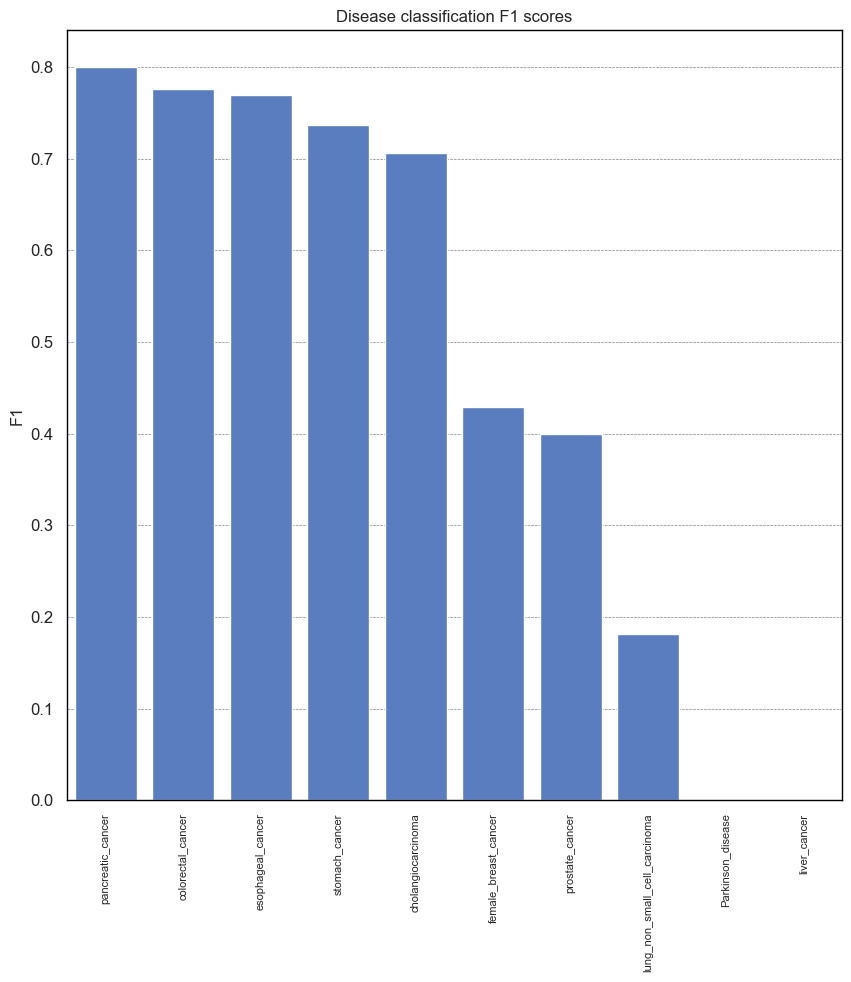

In [19]:
f1_all_labels_df = pd.DataFrame({'F1': f1_all_labels, 'Disease': all_diseases_list_threshold})
f1_all_labels_df = f1_all_labels_df.sort_values(by='F1', ascending=False)

plt.figure(figsize=(10, 10))
sns.barplot(data=f1_all_labels_df, x='Disease', y='F1')
plt.xticks(rotation=90, fontsize=8)
plt.xlabel(None)
plt.title('Disease classification F1 scores')
plt.savefig(config['paths']['figures_dir']+'/disease_classification.png')
plt.show()

#### 3. Protein binding prediction

The third task is predicting protein-glycan binding. This is a regression task (to predict binding score) but due to computational reasons, we can simpilfy it to classification. glycan-protein pairs with Z>2 are considered positive samples and those with Z<-2 are considered negative samples.

In [20]:
cols_to_keep = df_bind.columns[0:-110].values.tolist() + ['target']

df_bind_long = df_bind[cols_to_keep].melt(
    id_vars=['target'],        
    var_name='glycan',         
    value_name='BindingScore'  
).dropna().drop_duplicates()

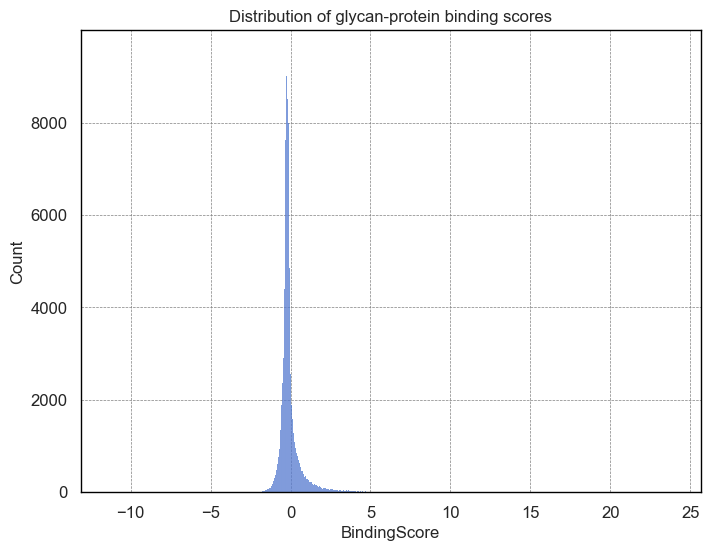

In [21]:
plt.figure()
sns.histplot(data=df_bind_long, x="BindingScore")
plt.title('Distribution of glycan-protein binding scores')
plt.savefig(config['paths']['figures_dir']+'/binding_score_distribution.png')
plt.show()

In [22]:
# make the output binary
df_bind_long['BindingBinary'] = 0
threshold = 2
df_bind_long.loc[df_bind_long['BindingScore']>threshold, 'BindingBinary'] = 1
df_bind_long.loc[df_bind_long['BindingScore']<-threshold, 'BindingBinary'] = -1
df_bind_long = df_bind_long[df_bind_long['BindingBinary'] != 0]

df_bind_long.head()


,target,glycan,BindingScore,BindingBinary
20515,ACPSQCSCSGTEVNCAGKSLASVPAGIPTTTRVLYLNSNQITKLEP...,Fuc(a1-2)Gal,13.184414,1
20575,AQQGVFTLPARINFGVTVLVNSAATQHVEIFVDNEPRAAFSGVGTG...,Fuc(a1-2)Gal,2.572536,1
20589,ATQGVFTLPANTRFGVTAFANSSGTQTVNVLVNNETAATFSGQSTN...,Fuc(a1-2)Gal,2.258602,1
20697,DTLCIGYHANNSTDTVDTVLEKNVTVTHSVNLLEDKHNGKLCKLRG...,Fuc(a1-2)Gal,3.024426,1
20935,MALRVLLLTALTLCHGFNLDTENAMTFQENARGFGQSVVQLQGSRV...,Fuc(a1-2)Gal,3.145829,1


To train the model, we should extract features from protein sequences. One way is using pretrained protein language models like ESM2 or ProtBert. But running them can be time-consuming and GPU-heavy. So here we extract simple features including amino acid composition, molecular weight, isoelectric point, aromaticity, and instability index.

In [23]:
# extract some features from protein sequences

prot_seqs = list(set(df_bind_long['target'].values.tolist()))
prot_features = {}

# Analyze each sequence
for seq in prot_seqs:

    try:
        analysis = ProteinAnalysis(seq)

        # Amino acid composition
        aa_composition = analysis.get_amino_acids_percent()

        # Molecular weight
        mw = analysis.molecular_weight()

        # Isoelectric point
        pI = analysis.isoelectric_point()

        # Aromaticity
        aromaticity = analysis.aromaticity()

        # Instability Index
        instability_index = analysis.instability_index()

        prot_features[seq] = {'mw': mw,
                            'pI': pI,
                            'aromaticity':aromaticity,
                            'instability_index':instability_index}
        
        for AA, value in aa_composition.items():
            prot_features[seq][AA+'_composition'] = value

    except:
        print(f'problem in analyzing {seq[0:10]}...')


prot_features_df = pd.DataFrame(prot_features).T
prot_features_df.reset_index(inplace=True)
prot_features_df.rename(columns={'index': 'target'}, inplace=True)
prot_features_df.head()

problem in analyzing MLSLKNLQNI...
problem in analyzing MKAILVVLLY...
problem in analyzing AEEAFDLWNE...
problem in analyzing MTRVLAIYIT...
problem in analyzing MKSLTYFWLF...
problem in analyzing LEEGEITSKV...
problem in analyzing MKAILVVLLY...
problem in analyzing MKEYQVYLER...
problem in analyzing MKAXLLXLLC...
problem in analyzing MKAILVVLLY...
problem in analyzing QKLPGNDNST...
problem in analyzing MEEFQRYLKL...
problem in analyzing MSYYHHHHHH...
problem in analyzing DEXLLLDIID...
problem in analyzing SLTHRKFGGS...
problem in analyzing MKILIFAFLA...


,target,mw,pI,aromaticity,instability_index,A_composition,C_composition,D_composition,E_composition,F_composition,...,M_composition,N_composition,P_composition,Q_composition,R_composition,S_composition,T_composition,V_composition,W_composition,Y_composition
0,MNQEKRLHRFVKKCGLGVCSAVVAAFLLNAQGVALATEQGNRPVET...,73596.5965,8.873702,0.085714,22.208872,0.093233,0.003008,0.043609,0.066165,0.034586,...,0.007519,0.072180,0.031579,0.052632,0.046617,0.066165,0.078195,0.091729,0.013534,0.037594
1,MKANLLVLLCALAAADADTICIGYHANNSTDTVDTVLEKNVTVTHS...,63381.1123,6.681958,0.095406,37.644735,0.058304,0.028269,0.037102,0.068905,0.033569,...,0.017668,0.086572,0.035336,0.030035,0.037102,0.081272,0.049470,0.058304,0.017668,0.044170
2,MKAILVVLLYTFTTANADTLCIGYHANNSTDTVDTVLEKNVTVTHS...,63357.8973,7.516866,0.100707,32.210636,0.058304,0.026502,0.044170,0.060071,0.035336,...,0.012367,0.074205,0.031802,0.026502,0.037102,0.084806,0.068905,0.063604,0.017668,0.047703
3,LPQDVTRCSANTNFRRFFSKFNVQAPAVVVLGGYLPIGENQGVNST...,93412.2618,6.032800,0.120283,30.113962,0.054245,0.028302,0.047170,0.036557,0.063679,...,0.005896,0.066038,0.060142,0.038915,0.024764,0.087264,0.076651,0.086085,0.010613,0.045991
4,MYMSKYVPVYTLLILIYSFNASAEWTGDNTNAYYSDEVISELHVGQ...,16045.9823,7.733877,0.139860,37.472098,0.076923,0.027972,0.027972,0.027972,0.048951,...,0.013986,0.048951,0.041958,0.041958,0.013986,0.111888,0.069930,0.083916,0.020979,0.069930


In [24]:
df_bind_long_wfeatues = df_bind_long.merge(prot_features_df, how='left')\
    .merge(all_embeds_df[['glycan'] + pc_cols], how = 'left')\
    .dropna()\
    .drop_duplicates()

df_bind_long_wfeatues.head()

,target,glycan,BindingScore,BindingBinary,mw,pI,aromaticity,instability_index,A_composition,C_composition,...,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13
0,ACPSQCSCSGTEVNCAGKSLASVPAGIPTTTRVLYLNSNQITKLEP...,Fuc(a1-2)Gal,13.184414,1,23716.8382,7.139284,0.064220,35.470642,0.064220,0.045872,...,0.782634,2.945741,-3.250521,-1.333369,1.84241,0.606414,-2.064746,-3.495395,-0.197014,-2.963757
1,AQQGVFTLPARINFGVTVLVNSAATQHVEIFVDNEPRAAFSGVGTG...,Fuc(a1-2)Gal,2.572536,1,11841.0484,4.563114,0.053097,21.841593,0.079646,0.000000,...,0.782634,2.945741,-3.250521,-1.333369,1.84241,0.606414,-2.064746,-3.495395,-0.197014,-2.963757
2,ATQGVFTLPANTRFGVTAFANSSGTQTVNVLVNNETAATFSGQSTN...,Fuc(a1-2)Gal,2.258602,1,11731.6775,4.050028,0.061404,13.283333,0.087719,0.000000,...,0.782634,2.945741,-3.250521,-1.333369,1.84241,0.606414,-2.064746,-3.495395,-0.197014,-2.963757
3,DTLCIGYHANNSTDTVDTVLEKNVTVTHSVNLLEDKHNGKLCKLRG...,Fuc(a1-2)Gal,3.024426,1,61425.6451,6.775458,0.098361,33.833916,0.054645,0.027322,...,0.782634,2.945741,-3.250521,-1.333369,1.84241,0.606414,-2.064746,-3.495395,-0.197014,-2.963757
4,MALRVLLLTALTLCHGFNLDTENAMTFQENARGFGQSVVQLQGSRV...,Fuc(a1-2)Gal,3.145829,1,127177.0047,6.879644,0.083333,39.253819,0.059896,0.019965,...,0.782634,2.945741,-3.250521,-1.333369,1.84241,0.606414,-2.064746,-3.495395,-0.197014,-2.963757


We use PCs (and not embeddings) as well as protein featyres to train and evaluate the model

In [25]:
all_features = pc_cols + prot_features_df.columns.values.tolist()[1:]
model_bind, f1_macro, f1_all_labels, accuracy = train_classifier(df_bind_long_wfeatues, all_features, 'BindingBinary', multi_label=False, max_iter=200, n_jobs=4, normalize=True)

In [29]:
print(f'F1 macro is {f1_macro}\n Accuracy is {accuracy}')

F1 macro is 0.4650315867707172
 Accuracy is 0.7465962767435399


### Applying models to the glycan_list

Now that we have 3 models for species/disease/binding prediction, we can use them to enrich the glycan list:

In [34]:
df_glycan_list_embeds = df_glycan_list.merge(all_embeds_df, how='left')
df_glycan_list_embeds

,glycan,Composition,tissue_species,tissue_sample,embed0,embed1,embed2,embed3,embed4,embed5,...,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13
0,Fuc(a1-?)GlcNAc(b1-2)Man(a1-6)[GlcNAc(b1-2)Man...,"{'dHex': 2, 'HexNAc': 4, 'Hex': 3}",['Homo_sapiens'],['blood'],-0.726562,-0.783203,-0.204468,0.195557,0.282715,-0.399902,...,0.805444,2.609657,0.801326,-1.731209,0.268810,-0.100343,0.682515,-0.462751,-0.228986,0.837098
1,Neu5Ac(a2-?)Gal(b1-4)GlcNAc(b1-2)Man(a1-6)[Glc...,"{'Neu5Ac': 1, 'Hex': 4, 'HexNAc': 4, 'dHex': 1}",['Homo_sapiens'],['blood'],-0.787109,-0.782715,-0.052582,0.238647,0.373291,-0.503418,...,0.775231,1.567503,0.862480,-0.870034,-0.327286,0.006661,0.130761,0.524260,0.536908,0.584762
2,Neu5Ac(a2-6)Gal(b1-4)GlcNAc(b1-2)Man(a1-6)[Gal...,"{'Neu5Ac': 1, 'Hex': 5, 'HexNAc': 4}",['Homo_sapiens'],['blood'],-0.763672,-0.827148,-0.035278,0.363525,0.381104,-0.434082,...,0.982264,0.707023,0.591388,-0.576860,-0.054340,0.769216,-0.001576,0.513497,0.400465,0.430991
3,Neu5Ac(a2-6)Gal(b1-4)GlcNAc(b1-2)Man(a1-6)[Glc...,"{'Neu5Ac': 1, 'Hex': 4, 'HexNAc': 4}",['Homo_sapiens'],['blood'],-0.757324,-0.907715,-0.06073,0.37915,0.379639,-0.455566,...,0.896593,0.925647,0.666009,-0.694196,0.046129,0.564545,0.228365,0.573361,0.313591,0.773804
4,Fuc(a1-2)[GalNAc(a1-3)]Gal(b1-4)GlcNAc(b1-2)Ma...,"{'dHex': 1, 'HexNAc': 5, 'Hex': 5}",['Homo_sapiens'],['blood'],-0.755859,-0.744141,-0.15918,0.256104,0.38623,-0.382812,...,0.600356,1.108948,0.510954,-0.859827,0.566268,0.059706,-0.273570,-0.733353,-0.157482,-0.434516


#### species prediction

species is available in the dataset, but it's worth checking if the model can predict it!

In [37]:
model_species.predict(df_glycan_list_embeds[embeds_cols])

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]])

all the glycans have 1 in their 5th index. which corresponds to human:

In [40]:
labels_names[5]

'Species_Homo_sapiens'

In [ ]:
df_glycan_list['predicted_species'] = labels_names[5]

#### disease prediction

In [41]:
model_disease.predict(df_glycan_list_embeds[pc_cols])

array([[0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]])

first and last glycan are predicted to be associated with the 3rd index disease:

In [42]:
all_diseases_list_threshold[3]

'colorectal_cancer'

In [47]:
df_glycan_list['predicted_disease'] = None
df_glycan_list.loc[0, 'predicted_disease'] = all_diseases_list_threshold[3]
df_glycan_list.loc[4, 'predicted_disease'] = all_diseases_list_threshold[3]

#### protein binding

In [53]:
df_glycan_list_embeds_and_protfeatures = df_glycan_list_embeds.merge( prot_features_df, how='cross')

In [71]:
df_glycan_list_embeds_and_protfeatures['binding'] = model_bind.predict(df_glycan_list_embeds_and_protfeatures[all_features])

In [79]:
binding_proteins = df_glycan_list_embeds_and_protfeatures[df_glycan_list_embeds_and_protfeatures['binding']==1]\
    .groupby('glycan')['target']\
    .apply(list)\
    .reset_index()
binding_proteins.rename(columns={'target':'binds_to'}, inplace=True)

not_binding_proteins = df_glycan_list_embeds_and_protfeatures[df_glycan_list_embeds_and_protfeatures['binding']==1]\
    .groupby('glycan')['target']\
    .apply(list)\
    .reset_index()
not_binding_proteins.rename(columns={'target':'doesnt_bind_to'}, inplace=True)

Saving the enriched glycan list:

In [84]:
df_glycan_list_enriched = df_glycan_list.merge(binding_proteins, how='left')\
    .merge(not_binding_proteins, how='left')

df_glycan_list_enriched.to_csv('../results/misc/df_glycan_list_enriched/df_glycan_list_enriched.csv.gz')
df_glycan_list_enriched

,glycan,Composition,tissue_species,tissue_sample,predicted_species,predicted_disease,binds_to,doesnt_bind_to
0,Fuc(a1-?)GlcNAc(b1-2)Man(a1-6)[GlcNAc(b1-2)Man...,"{'dHex': 2, 'HexNAc': 4, 'Hex': 3}",['Homo_sapiens'],['blood'],Species_Homo_sapiens,colorectal_cancer,[MNQEKRLHRFVKKCGLGVCSAVVAAFLLNAQGVALATEQGNRPVE...,[MNQEKRLHRFVKKCGLGVCSAVVAAFLLNAQGVALATEQGNRPVE...
1,Neu5Ac(a2-?)Gal(b1-4)GlcNAc(b1-2)Man(a1-6)[Glc...,"{'Neu5Ac': 1, 'Hex': 4, 'HexNAc': 4, 'dHex': 1}",['Homo_sapiens'],['blood'],Species_Homo_sapiens,None,[MNQEKRLHRFVKKCGLGVCSAVVAAFLLNAQGVALATEQGNRPVE...,[MNQEKRLHRFVKKCGLGVCSAVVAAFLLNAQGVALATEQGNRPVE...
2,Neu5Ac(a2-6)Gal(b1-4)GlcNAc(b1-2)Man(a1-6)[Gal...,"{'Neu5Ac': 1, 'Hex': 5, 'HexNAc': 4}",['Homo_sapiens'],['blood'],Species_Homo_sapiens,None,[MNQEKRLHRFVKKCGLGVCSAVVAAFLLNAQGVALATEQGNRPVE...,[MNQEKRLHRFVKKCGLGVCSAVVAAFLLNAQGVALATEQGNRPVE...
3,Neu5Ac(a2-6)Gal(b1-4)GlcNAc(b1-2)Man(a1-6)[Glc...,"{'Neu5Ac': 1, 'Hex': 4, 'HexNAc': 4}",['Homo_sapiens'],['blood'],Species_Homo_sapiens,None,[MNQEKRLHRFVKKCGLGVCSAVVAAFLLNAQGVALATEQGNRPVE...,[MNQEKRLHRFVKKCGLGVCSAVVAAFLLNAQGVALATEQGNRPVE...
4,Fuc(a1-2)[GalNAc(a1-3)]Gal(b1-4)GlcNAc(b1-2)Ma...,"{'dHex': 1, 'HexNAc': 5, 'Hex': 5}",['Homo_sapiens'],['blood'],Species_Homo_sapiens,colorectal_cancer,[MNQEKRLHRFVKKCGLGVCSAVVAAFLLNAQGVALATEQGNRPVE...,[MNQEKRLHRFVKKCGLGVCSAVVAAFLLNAQGVALATEQGNRPVE...
